In [52]:
import numpy as np
from keras.datasets import cifar10
from keras.models import Sequential, Model
from keras.layers import Dense
from keras.layers import Dropout
from keras.utils import np_utils
from keras.optimizers import RMSprop, Adam, SGD
from keras_tqdm import TQDMNotebookCallback
from keras.callbacks import EarlyStopping
from keras.layers import Flatten, Reshape, BatchNormalization, Activation, LeakyReLU, Input, GaussianNoise, Conv2DTranspose, merge
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import UpSampling2D
from keras import backend as K
K.set_image_dim_ordering('tf')
import matplotlib.pyplot as plt
import random
import cv2
import glob
import os

In [2]:
# For reproducibility
np.random.seed(42)

In [3]:
def crop_center(img,cropx,cropy):
    y,x,c = img.shape
    startx = x//2 - cropx//2
    starty = y//2 - cropy//2
    cropped_img = np.copy(img[starty:starty+cropy, startx:startx+cropx, :])
    masked_img = img.copy()
    masked_img[starty:starty+cropy, startx:startx+cropx, :] = 0
    return (masked_img, cropped_img)

In [39]:
def build_generator(input_shape):
    
    inputs = Input(shape=input_shape)
    # Layer 1
    x = Conv2D(64, kernel_size=5, activation="relu", strides = 1, padding="same")(norm)
    norm = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(64, kernel_size=5, activation="relu", padding="same")(norm)
    norm = BatchNormalization(momentum=0.8)(x)
    # Layer 2
    x = Conv2D(128, kernel_size=3, activation="relu", strides = 2, padding="same")(norm) # 256 -> 128
    norm = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(128, kernel_size=3, activation="relu", padding="same")(norm)
    norm = BatchNormalization(momentum=0.8)(x)
    # Layer 3
    x = Conv2D(256, kernel_size=3, activation="relu", strides = 2, padding="same")(norm) # 128 -> 64
    norm = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(256, kernel_size=3, activation="relu", padding="same")(norm)
    norm = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(256, kernel_size=3, activation="relu", padding="same")(norm)
    norm = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(256, kernel_size=3, activation="relu", dilation_rate=2, padding="same")(norm) # Dilated Rate = 2
    norm = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(256, kernel_size=3, activation="relu", dilation_rate=4, padding="same")(norm) # Dilated Rate = 4
    norm = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(256, kernel_size=3, activation="relu", dilation_rate=8, padding="same")(norm) # Dilated Rate = 8
    norm = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(256, kernel_size=3, activation="relu", dilation_rate=16, padding="same")(norm) # Dilated Rate = 8
    norm = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(256, kernel_size=3, activation="relu", padding="same")(norm)
    norm = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(256, kernel_size=3, activation="relu", padding="same")(norm)
    norm = BatchNormalization(momentum=0.8)(x)
    # Layer 4 - DeConv
    x = Conv2DTranspose(128, kernel_size=4, activation="relu", strides=2, padding="same")(norm) # 64 -> 128
    norm = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(128, kernel_size=3, activation="relu", padding="same")(norm)
    norm = BatchNormalization(momentum=0.8)(x)
    # Layer 5 - DeConv
    x = Conv2DTranspose(64, kernel_size=4, activation="relu", strides=2, padding="same")(norm) # 128 -> 256
    norm = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(32, kernel_size=3, activation="relu", padding="same")(norm)
    output = Conv2D(3, kernel_size=3, activation="tanh", padding="same")(x)
    
    # Create Model
    model = Model(inputs=inputs, outputs=output)
    return model

def build_discriminator(img_shape, missing_shape):
    
    input_local = Input(missing_shape)
    # Local Discriminator
    x = Conv2D(64, kernel_size=5, activation="relu", strides=2, padding="same")(input_local) # 128 -> 64
    norm = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(128, kernel_size=5, activation="relu", strides=2, padding="same")(norm) # 64 -> 32
    norm = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(256, kernel_size=5, activation="relu", strides=2, padding="same")(norm) # 32 -> 16
    norm = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(512, kernel_size=5, activation="relu", strides=2, padding="same")(norm) # 16 -> 8
    norm = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(512, kernel_size=5, activation="relu", strides=2, padding="same")(norm) # 8 -> 4
    output_local = Dense(1024, activation="relu")(x)
    
    input_global = Input(img_shape)
    # Global Discriminator
    x = Conv2D(64, kernel_size=5, activation="relu", strides=2, padding="same")(input_local) # 256 -> 128
    norm = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(128, kernel_size=5, activation="relu", strides=2, padding="same")(norm) # 128 -> 64
    norm = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(256, kernel_size=5, activation="relu", strides=2, padding="same")(norm) # 64 -> 32
    norm = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(512, kernel_size=5, activation="relu", strides=2, padding="same")(norm) # 32 -> 16
    norm = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(512, kernel_size=5, activation="relu", strides=2, padding="same")(norm) # 16 -> 8
    norm = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(512, kernel_size=5, activation="relu", strides=2, padding="same")(norm) # 8 -> 8
    output_global = Dense(1024, activation="relu")(x)
    
    # Concat
    input_concat = concatenate([output_local, output_global], axis=-1)
    output_all = Dense(2048, activation="relu")(input_concat)
    
    # Create Model
    model = Model(inputs=input_concat, outputs=output_all)
    return model

In [73]:
d_optim = Adam(lr=0.00002, beta_1=0.5)
g_optim = Adam(lr=0.0002, beta_1=0.5)

model_discriminator = build_discriminator()
#model_discriminator.load_weights('discriminator_places')
model_discriminator.compile(loss='binary_crossentropy',
            optimizer=d_optim,
            metrics=['accuracy'])

model_generator = build_generator()
#model_generator.load_weights('generator_places')

masked_img = Input(shape=(256,256,3))
gen_missing = model_generator(masked_img)
model_discriminator.trainable = False

valid = model_discriminator(gen_missing)

model_gan = Model(masked_img , [gen_missing, valid])
model_gan.compile(loss=['mse', 'binary_crossentropy'],
            loss_weights=[0.999, 0.0001],
            optimizer=g_optim)

In [28]:
def get_images(batch_size, folders, is_trainig):
    random_folders = random.sample(folders, batch_size)
    images = []
    for f in random_folders:
        number = 0
        if is_trainig:
            number = str(random.randint(1, 4900))
        else:
            number = str(random.randint(4901, 5000))
        filename = number.zfill(8) + ".jpg"
        img = cv2.imread(os.path.join(f[0],filename))
        if img is not None:
            images.append(img)
    images = np.array(images)
    X = []
    Y = []
    for i in images:
        img = crop_center(i, 128, 128)
        X.append(img[0])
        Y.append(img[1])
    X_array = np.array(X)
    Y_array = np.array(Y)
    X_array = (X_array.astype(np.float32) - 127.5)/127.5
    Y_array = (Y_array.astype(np.float32) - 127.5)/127.5
    return (X_array, Y_array)

In [29]:
folder = "Places/places365standard_easyformat/places365_standard/train/"
folders = list(os.walk(folder))

wait_epochs = 0

def train(train_steps=1000000, batch_size=32):
    skip_d = 0
    for i in range(train_steps):
                
        # ---------------------
        #  Get Images
        # ---------------------
        
        X, Y = get_images(batch_size, folders, True)
        
        # ---------------------
        #  Train Discriminator
        # ---------------------
        
        # Random input
        missing_part = Y
        masked_imgs = X
        gen_missing_part = model_generator.predict(masked_imgs)
        
        # Valid and fake outputs (flipping)
        valid = np.ones([X.shape[0], 1])
        fake = np.zeros([X.shape[0], 1])
        
        if skip_d == 0:
            # Train discriminator
            d_loss_valid = model_discriminator.train_on_batch(missing_part, valid)
            d_loss_fake = model_discriminator.train_on_batch(gen_missing_part, fake)
            d_loss = 0.5 * np.add(d_loss_valid, d_loss_fake)
            if (d_loss[0] < 0.01):
                skip_d = wait_epochs
        else:
            skip_d -= 1
        
        # ---------------------
        #  Train Generator
        # ---------------------
        g_loss = model_gan.train_on_batch(masked_imgs, [missing_part, valid])
        
        
        # ---------------------
        #  Logs
        # ---------------------
        if i % 100 == 0:
                model_generator.save_weights('generator_places2', True)
                model_discriminator.save_weights('discriminator_places2', True)
        if i % 10 == 0:
            print ("%d [D loss: %f, acc: %.2f%%] [G loss: %f, mse: %f]" % (i, d_loss[0], 100*d_loss[1], g_loss[0], g_loss[1]))

In [30]:
train()

C:\Users\Marcelo\Anaconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py:975: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


ResourceExhaustedError: OOM when allocating tensor with shape[512,256,3,3] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: model_20/sequential_14/conv2d_132/convolution = Conv2D[T=DT_FLOAT, _class=["loc:@train...kpropInput"], data_format="NCHW", dilations=[1, 1, 1, 1], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](model_20/sequential_14/conv2d_132/convolution-0-TransposeNHWCToNCHW-LayoutOptimizer, conv2d_132/kernel/read)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Node: model_20/sequential_14/batch_normalization_132/Shape/_12509 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_1885_model_20/sequential_14/batch_normalization_132/Shape", tensor_type=DT_INT32, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'model_20/sequential_14/conv2d_132/convolution', defined at:
  File "C:\Users\Marcelo\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Marcelo\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Marcelo\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "C:\Users\Marcelo\Anaconda3\envs\tensorflow\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\Marcelo\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelapp.py", line 486, in start
    self.io_loop.start()
  File "C:\Users\Marcelo\Anaconda3\envs\tensorflow\lib\site-packages\tornado\platform\asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "C:\Users\Marcelo\Anaconda3\envs\tensorflow\lib\asyncio\base_events.py", line 421, in run_forever
    self._run_once()
  File "C:\Users\Marcelo\Anaconda3\envs\tensorflow\lib\asyncio\base_events.py", line 1425, in _run_once
    handle._run()
  File "C:\Users\Marcelo\Anaconda3\envs\tensorflow\lib\asyncio\events.py", line 127, in _run
    self._callback(*self._args)
  File "C:\Users\Marcelo\Anaconda3\envs\tensorflow\lib\site-packages\tornado\platform\asyncio.py", line 117, in _handle_events
    handler_func(fileobj, events)
  File "C:\Users\Marcelo\Anaconda3\envs\tensorflow\lib\site-packages\tornado\stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\Marcelo\Anaconda3\envs\tensorflow\lib\site-packages\zmq\eventloop\zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "C:\Users\Marcelo\Anaconda3\envs\tensorflow\lib\site-packages\zmq\eventloop\zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\Marcelo\Anaconda3\envs\tensorflow\lib\site-packages\zmq\eventloop\zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\Marcelo\Anaconda3\envs\tensorflow\lib\site-packages\tornado\stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\Marcelo\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Users\Marcelo\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Users\Marcelo\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "C:\Users\Marcelo\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\Marcelo\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\Marcelo\Anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "C:\Users\Marcelo\Anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\Marcelo\Anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Users\Marcelo\Anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-27-6ec3d1356f76>", line 14, in <module>
    gen_missing = model_generator(masked_img)
  File "C:\Users\Marcelo\Anaconda3\envs\tensorflow\lib\site-packages\keras\engine\topology.py", line 619, in __call__
    output = self.call(inputs, **kwargs)
  File "C:\Users\Marcelo\Anaconda3\envs\tensorflow\lib\site-packages\keras\engine\topology.py", line 2085, in call
    output_tensors, _, _ = self.run_internal_graph(inputs, masks)
  File "C:\Users\Marcelo\Anaconda3\envs\tensorflow\lib\site-packages\keras\engine\topology.py", line 2235, in run_internal_graph
    output_tensors = _to_list(layer.call(computed_tensor, **kwargs))
  File "C:\Users\Marcelo\Anaconda3\envs\tensorflow\lib\site-packages\keras\models.py", line 579, in call
    return self.model.call(inputs, mask)
  File "C:\Users\Marcelo\Anaconda3\envs\tensorflow\lib\site-packages\keras\engine\topology.py", line 2085, in call
    output_tensors, _, _ = self.run_internal_graph(inputs, masks)
  File "C:\Users\Marcelo\Anaconda3\envs\tensorflow\lib\site-packages\keras\engine\topology.py", line 2235, in run_internal_graph
    output_tensors = _to_list(layer.call(computed_tensor, **kwargs))
  File "C:\Users\Marcelo\Anaconda3\envs\tensorflow\lib\site-packages\keras\layers\convolutional.py", line 168, in call
    dilation_rate=self.dilation_rate)
  File "C:\Users\Marcelo\Anaconda3\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py", line 3341, in conv2d
    data_format=tf_data_format)
  File "C:\Users\Marcelo\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\nn_ops.py", line 780, in convolution
    return op(input, filter)
  File "C:\Users\Marcelo\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\nn_ops.py", line 868, in __call__
    return self.conv_op(inp, filter)
  File "C:\Users\Marcelo\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\nn_ops.py", line 520, in __call__
    return self.call(inp, filter)
  File "C:\Users\Marcelo\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\nn_ops.py", line 505, in _with_space_to_batch_call
    result = self.op(input_converted, filter)
  File "C:\Users\Marcelo\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\nn_ops.py", line 204, in __call__
    name=self.name)
  File "C:\Users\Marcelo\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\gen_nn_ops.py", line 1042, in conv2d
    data_format=data_format, dilations=dilations, name=name)
  File "C:\Users\Marcelo\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\Marcelo\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\ops.py", line 3392, in create_op
    op_def=op_def)
  File "C:\Users\Marcelo\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\ops.py", line 1718, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[512,256,3,3] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: model_20/sequential_14/conv2d_132/convolution = Conv2D[T=DT_FLOAT, _class=["loc:@train...kpropInput"], data_format="NCHW", dilations=[1, 1, 1, 1], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](model_20/sequential_14/conv2d_132/convolution-0-TransposeNHWCToNCHW-LayoutOptimizer, conv2d_132/kernel/read)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Node: model_20/sequential_14/batch_normalization_132/Shape/_12509 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_1885_model_20/sequential_14/batch_normalization_132/Shape", tensor_type=DT_INT32, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.



In [9]:
def append_image(img,cropped_image, cropx, cropy):
    y,x,c = img.shape
    startx = x//2 - cropx//2
    starty = y//2 - cropy//2
    img_copy = np.copy(img)
    for k in range(len(img)):
        for p in range(len(img)):
            if (starty <= k < starty + cropy) and (startx <= p < startx + cropx):
                img_copy[p][k] = cropped_image[p - starty][k - startx]
            else:
                img_copy[p][k] = img_copy[p][k]
    return img_copy

In [10]:
def print_result(img):
    prediction = model_generator.predict(np.array([img]))
    img = (img + 1) * 127.5
    prediction = (prediction + 1) * 127.5
    result = append_image(img.astype(int), prediction[0], 128, 128)
    plt.imshow(result)
    
def print_original(img, img_cropped):
    img = (img + 1) * 127.5
    img_cropped = (img_cropped + 1) * 127.5
    result = append_image(img.astype(int), img_cropped.astype(int), 128, 128)
    plt.imshow(result)

In [11]:
X_test, Y_test = get_images(10, folders, False)

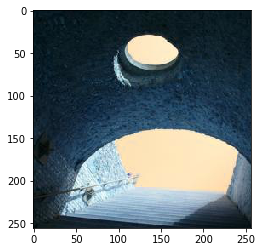

In [115]:
print_original(X_test[0], Y_test[0])

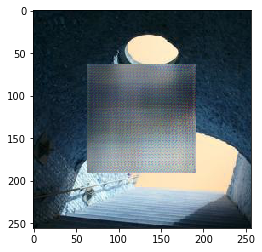

In [116]:
print_result(X_test[0])

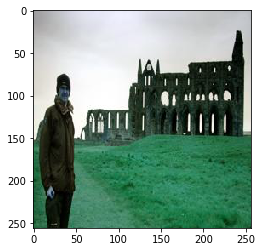

In [117]:
print_original(X_test[1], Y_test[1])

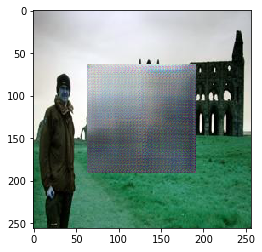

In [118]:
print_result(X_test[1])

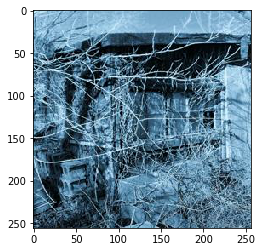

In [119]:
print_original(X_test[2], Y_test[2])

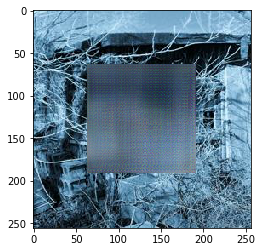

In [120]:
print_result(X_test[2])

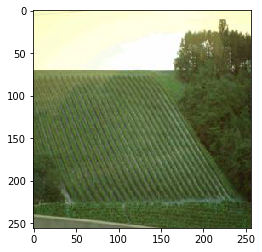

In [121]:
print_original(X_test[3], Y_test[3])

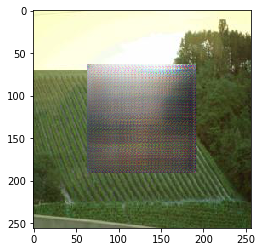

In [122]:
print_result(X_test[3])

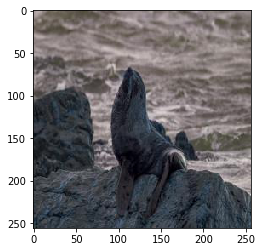

In [123]:
print_original(X_test[4], Y_test[4])

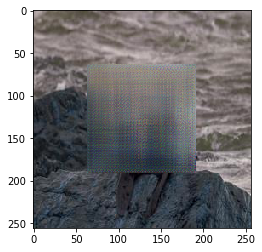

In [124]:
print_result(X_test[4])

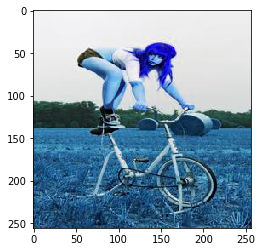

In [125]:
print_original(X_test[5], Y_test[5])

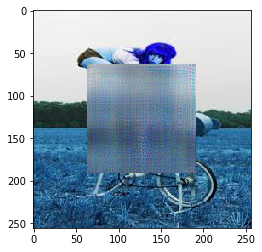

In [126]:
print_result(X_test[5])